<html>
<head>
<style>
h1 {text-align: center;}
p {text-align: center;}
div {text-align: center;}
</style>
</head>
<body>

<h1>Data analysis</h1>

<h3>Asbjørn Fyhn & Emil Kolko Beckett</h3>
<h3>Seminar: Topics in Sovereign Debt (Spring 2025)</h3>

</body>
</html>

In [1]:
# automatic reload of modules
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np
from datetime import datetime
from nelson_siegel_svensson.calibrate import calibrate_nss_ols
import statsmodels.api as sm; 
import warnings
import LinearModel as lm
import tools
from copy import deepcopy
import matplotlib.pyplot as plt

cmap = tools.colorway
plt.rcParams['font.family'] = 'serif' 

save_figs = True

path_to_data = r'/Users/asbjornfyhn/Desktop/Seminar - sovergin debt/Determinants/data/'
path_to_output = r'/Users/asbjornfyhn/Desktop/Seminar - sovergin debt/Determinants/output/'

# Load data 

In [2]:
df = pd.read_excel(path_to_data+'embi_regression_data.xlsx')
df['spread_bps'] = df['spread'] * 100

# We set non-defaulted bonds to 11 years since default
ysd_var = 'years_since_in_default' # years_since_new_default, years_since_in_default # last one yield better results
df['YEARS_SINCE_DEFAULT'] = df[ysd_var].copy(deep=True) 
df.loc[(df[ysd_var]>=11) | (df[ysd_var].isna()),'YEARS_SINCE_DEFAULT'] = 11.

pd.concat(
    [
        df.groupby('RISK_REGION')['Isin'].count().reset_index(drop=False),
        df.groupby('Date')['Isin'].count().reset_index(drop=False)
    ], axis=1, ignore_index=True
).rename(columns={0:'Region',1:'No. of Isins',2:'Date',3:'No. of Isins'})


,Region,No. of Isins,Date,No. of Isins
0,Africa,454,2018-12-31,705
1,Asia,2309,2019-12-31,797
2,Eastern Europe,632,2020-12-31,895
3,Latin America,1561,2021-12-31,1001
4,Middle East,1121,2022-12-31,940
5,North America,33,2023-12-31,903
6,Other,7,2024-12-31,876


## EMBI data
- Bonds without country code 
- Bonds with nominal yield of 0
- Removing after 2023-12-31

#### Credit rating
- Removing all bonds with a credit rating of below c to avoid insane outliers

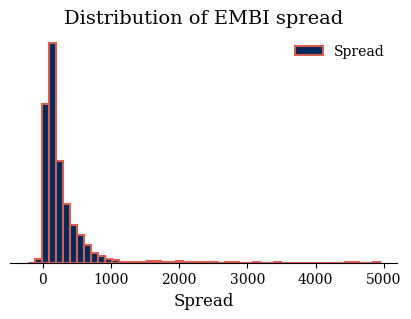

In [3]:
fig = plt.figure(figsize=(5, 3), )

ax = fig.add_subplot()
# ax.hist(df['spread'], bins=50, histtype='step', alpha=0.7,density=True, color=cmap[0])
# fill under the curve
ax.hist(df['spread_bps'], bins=50, histtype='bar', density=True, color=cmap[0], edgecolor=cmap[5], linewidth=1.5)
# Remove spines 
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['left'].set_visible(False)

# set title, xlabel and ylabel
ax.set_title('Distribution of EMBI spread', fontsize=14)
ax.set_xlabel('Spread', fontsize=12)

# remove yticks
ax.set_yticks([])
# add legend without box and title
ax.legend(['Spread'], loc='upper right', frameon=False, title=None)

if save_figs:
    plt.savefig(path_to_output+'embi_spread_histogram.png', dpi=300, bbox_inches='tight')

plt.show()

# Analysis

In [4]:
# Initialize the output table
ltx = lm.latex_output()

# Group by date and country
dfGroup = df.groupby(['Date','COUNTRY_NAME','RISK_REGION']).median().reset_index()

# Add log spread
dfGroup['log_spread'] = np.log(dfGroup['spread'])

# Remove defaulted countries
pos_default = ['Zambia','Venezuela','Lebanon','Ghana','Sri Lanka','Suriname','Ukraine','Belarus','Ecuador','Argentina','El Salvador','Russia','Pakistan','Etiopien','Maldives','Tajikistan'] # Consider Belarus
dfGroup = dfGroup.loc[~((dfGroup['COUNTRY_NAME'].isin(pos_default))&(dfGroup['spread']>8))] 

# Calculate time effect
dfGroup['Time_effect'] = dfGroup['Date'].dt.year - dfGroup['Date'].dt.year.min()

# Middle East 
dfGroup['ME_dummy'] = 0.; dfGroup.loc[dfGroup['RISK_REGION']=='Middle East','ME_dummy'] = 1.

# Remove countries with high spreads
dfGroup = dfGroup.loc[dfGroup['spread']<10]

dfBase = dfGroup.loc[dfGroup['RISK_REGION']!='Middle East']

### Diagnostics
First, we take the mean of all spread for all country $i$ at time $t$. Next, we plot all observations. 

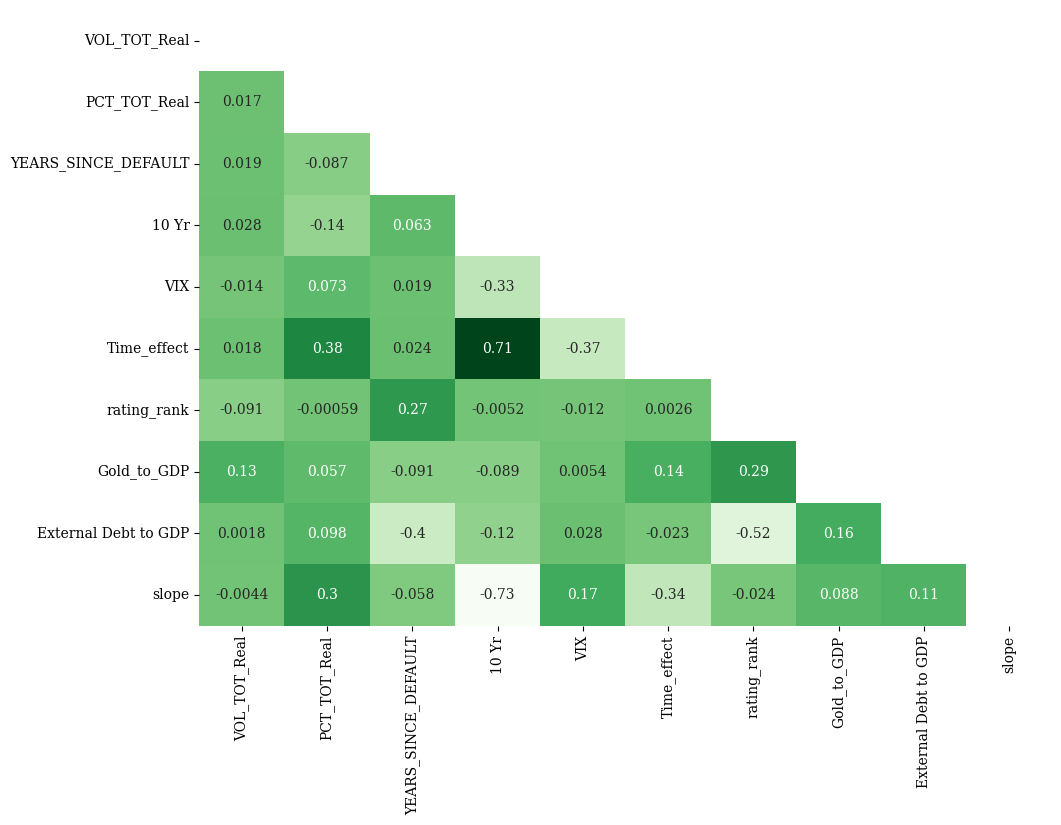

In [5]:
import seaborn as sns
corr = dfGroup[['VOL_TOT_Real','PCT_TOT_Real','YEARS_SINCE_DEFAULT','10 Yr','VIX','Time_effect','rating_rank','Gold_to_GDP','External Debt to GDP','slope']].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan

plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True, cbar=False)
plt.show()

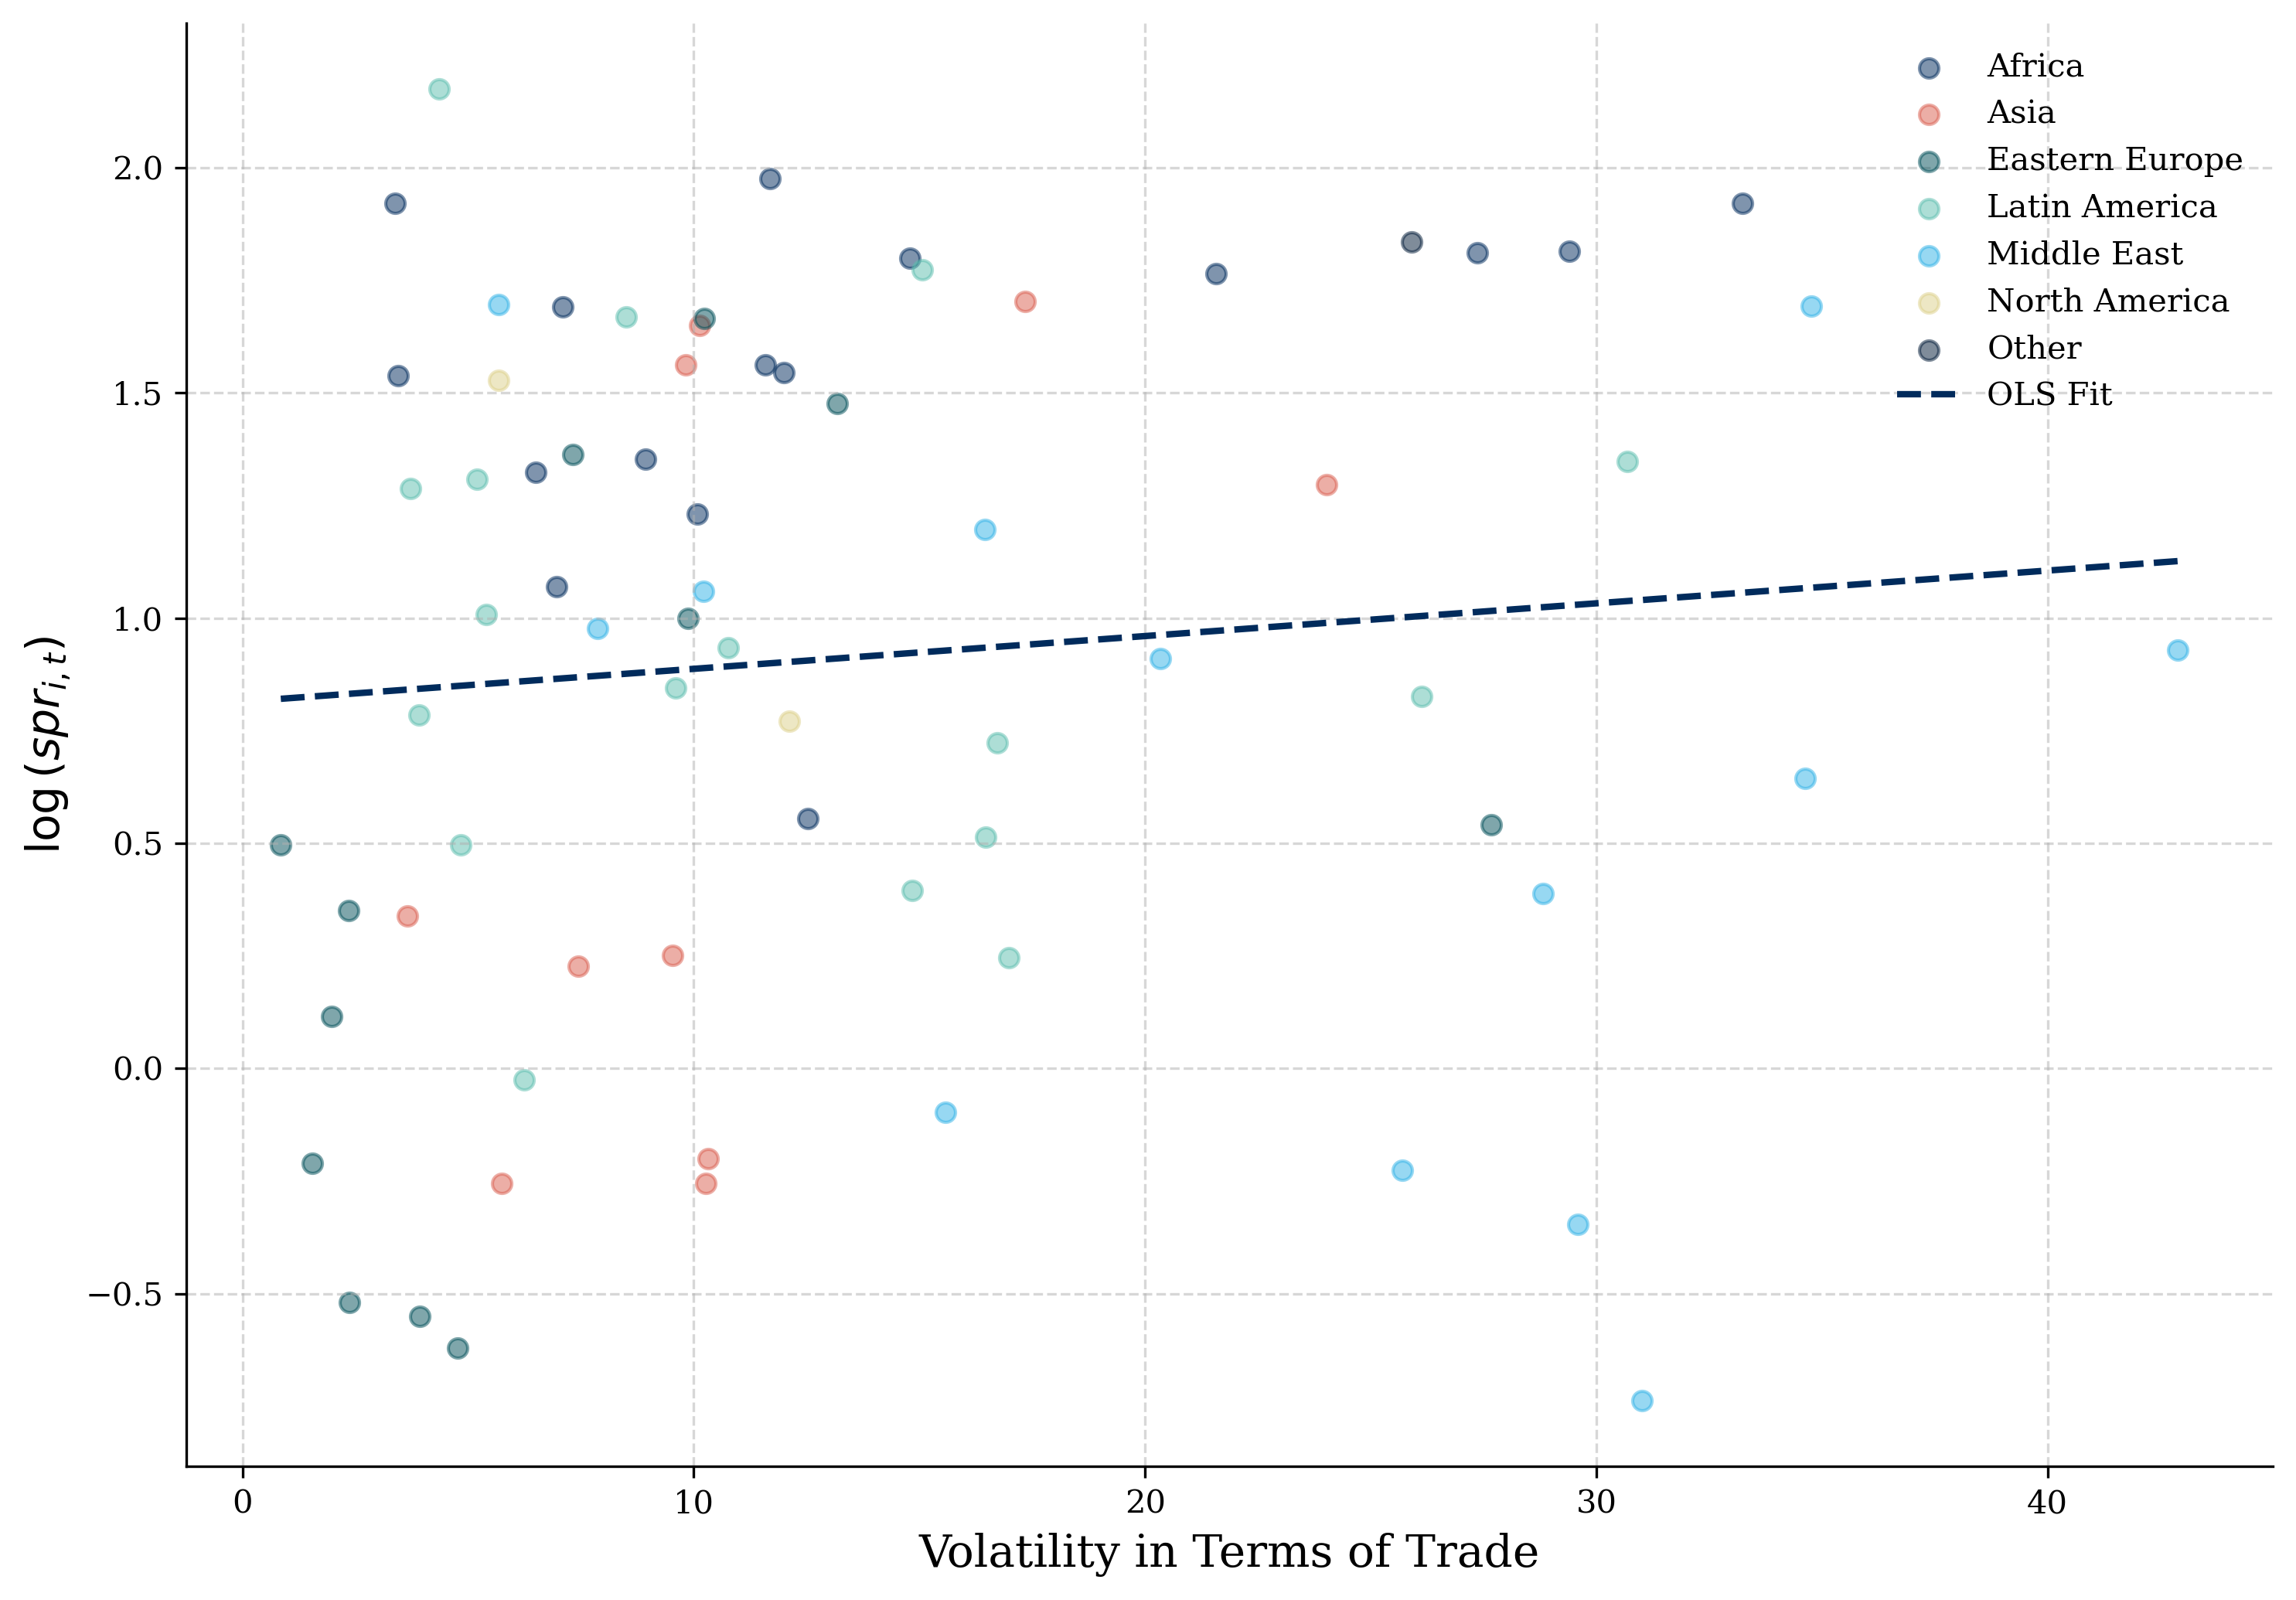

In [6]:
df_plot = deepcopy(dfGroup)
df_plot = df_plot.groupby('COUNTRY_NAME').agg({'log_spread':'mean','VOL_TOT_Real':'mean','RISK_REGION':'first'}).reset_index()

# Assign unique colors to each region
regions = df_plot['RISK_REGION'].unique()
color_map = {region: cmap[i] for i, region in enumerate(regions)}

fig = plt.figure(figsize=(10,7),dpi=300)
ax = fig.add_subplot()

# Scatter plot with colors based on region
for region, sub_df in df_plot.groupby('RISK_REGION'):
    ax.scatter(sub_df['VOL_TOT_Real'], sub_df['log_spread'], 
               alpha=0.5, label=region, 
               color=color_map[region])

# Fit a linear regression model
X = sm.add_constant(df_plot.dropna(subset=['VOL_TOT_Real','log_spread'])['VOL_TOT_Real'])
y = df_plot.dropna(subset=['VOL_TOT_Real','log_spread'])['log_spread']
model = sm.OLS(y, X).fit()
# Plot the regression line
x_vals = np.linspace(df_plot['VOL_TOT_Real'].min(), df_plot['VOL_TOT_Real'].max(), 100)
y_vals = model.predict(sm.add_constant(x_vals))
ax.plot(x_vals, y_vals, color=cmap[0], linewidth=2, label='OLS Fit',linestyle='--')

ax.set_xlabel('Volatility in Terms of Trade', fontsize=14)
ax.set_ylabel('$\log{(spr_{i,t})}$', fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend for clarity
ax.legend(frameon=False)  

ax.grid(axis='both', linestyle='--', alpha=0.5)

# if save_figs:
#     fig.savefig(path_to_output + 'scatter_log_spread.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [16]:
dfDesc = dfBase[['log_spread','spread','VOL_TOT_Real','PCT_TOT_Real','YEARS_SINCE_DEFAULT','10 Yr','VIX','Time_effect','rating_rank','Gold_to_GDP','External Debt to GDP','slope']].describe().T
dfDesc = dfDesc.rename(index={
    'log_spread':'$\log{spr}$', 
    'spread':'$spr$', 
    'VOL_TOT_Real':'Vol. ToT',
    'PCT_TOT_Real':'Chg. ToT',
    'YEARS_SINCE_DEFAULT':'YTD',
    }, ).drop(columns=['25%','75%']).rename(columns={'50%':'Median'})
dfDesc['count'] = dfDesc['count'].astype(int).astype(str)
dfDesc[['mean','std','min','max','Median']] = dfDesc[['mean','std','min','max','Median']].round(2)
dfDesc
desLatex = dfDesc.to_latex()

with open(path_to_output+'descriptive_stats.tex', 'w') as f:
    f.write(desLatex)

/var/folders/yb/hc1k3b754099lzy1_y8dq0xc0000gn/T/ipykernel_6804/861141882.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  desLatex = dfDesc.to_latex()


## Baseline model

In [7]:
print(
    dfBase['Date'].min(),
    dfBase['Date'].max()
)

2018-12-31 00:00:00 2024-12-31 00:00:00


In [13]:
print(
    dfBase[['log_spread','spread',]].median(),'\n',
    dfBase[['log_spread','spread',]].mean(),'\n',
    dfBase[['log_spread','spread',]].std(),
)
      


log_spread    0.955804
spread        2.600761
dtype: float64 
 log_spread    0.900876
spread        3.179489
dtype: float64 
 log_spread    0.763043
spread        2.124383
dtype: float64


In [8]:
# Define variables
labels = ('log_spread',['constant','VOL_TOT_Real','PCT_TOT_Real','YEARS_SINCE_DEFAULT','10 Yr','VIX','Time_effect','rating_rank','Gold_to_GDP','External Debt to GDP','slope']) #  # 

# Initialize the LinRegModel
regBase = lm.regression(dfBase, y=labels[0], X=labels[1])

# Run the regression
regBase.run_regression(verbose=False)
regBase.print_min_max('Date')

# # Add to model
# ltx.add_model(labels=labels[1],coefficients=regBase.results['b_hat'],se=regBase.results['tvalues'],N=regBase.results['nobs'], R2=regBase.results['R2'])

# Plot the residuals
#regBase.residual_plot()

Min: 2018-12-31 00:00:00
Max: 2021-12-31 00:00:00


## Regression for country variables

In [9]:
# Define variables
labels = ('log_spread',['constant','VOL_TOT_Real','PCT_TOT_Real','YEARS_SINCE_DEFAULT','10 Yr','VIX']) #  # 

# Initialize the LinRegModel
regCoun = lm.regression(dfBase, y=labels[0], X=labels[1])

# Run the regression
regCoun.run_regression(verbose=True)
# # Add to model
# ltx.add_model(labels=labels[1],coefficients=regCoun.results['b_hat'],se=regCoun.results['tvalues'],N=regCoun.results['nobs'], R2=regCoun.results['R2'])

# Plot the residuals
#regBase.residual_plot()

                             OLS Regression Results                             
--------------------------------------------------------------------------------
Dependent variable: ['log_spread']
Observations: 203.0
Parameters: 6
--------------------------------------------------------------------------------
                      b_hat      se  tvalues  pvalues signi.
constant             0.6262  0.3093   2.0243   0.0429     **
VOL_TOT_Real         0.0319  0.0054   5.8873   0.0000    ***
PCT_TOT_Real         0.0609  0.2796   0.2178   0.8276       
YEARS_SINCE_DEFAULT -0.0874  0.0198  -4.4183   0.0000    ***
10 Yr                0.1055  0.0748   1.4101   0.1585       
VIX                  0.0325  0.0115   2.8289   0.0047    ***
--------------------------------------------------------------------------------
R2 = 0.236
R2 Adj = 0.216
None


In [ ]:
# Model using 3 year pct change in ToT
labels_3y = ('log_spread',['constant','VOL_TOT_Real_3yr','PCT_TOT_Real_3yr','YEARS_SINCE_DEFAULT','10 Yr','VIX']) # Define variables
regCoun_3y = lm.regression(dfBase, y=labels_3y[0], X=labels_3y[1]) # Initialize the LinRegModel
regCoun_3y.run_regression(verbose=False) # Run the regression
# ltx.add_model(labels=labels_3y[1],coefficients=regCoun_3y.results['b_hat'],se=regCoun_3y.results['tvalues'],N=regCoun_3y.results['nobs'], R2=regCoun_3y.results['R2']) # Add to model

# Model using 1 year pct change in ToT
labels_1y = ('log_spread',['constant','VOL_TOT_Real_1yr','PCT_TOT_Real_1yr','YEARS_SINCE_DEFAULT','10 Yr','VIX']) # Define variables
regCoun_1yr = lm.regression(dfBase, y=labels_1y[0], X=labels_1y[1]) # Initialize the LinRegModel
regCoun_1yr.run_regression(verbose=False) # Run the regression
# ltx.add_model(labels=labels_1y[1],coefficients=regCoun_1yr.results['b_hat'],se=regCoun_1yr.results['tvalues'],N=regCoun_1yr.results['nobs'], R2=regCoun_1yr.results['R2']) # Add to model

# # Model using dummy for default
# labels_ysd = ('log_spread',['constant','VOL_TOT_Real','PCT_TOT_Real','YSD_dummy','10 Yr','VIX']) 
# regCoun_ysd = lm.regression(dfBase, y=labels_ysd[0], X=labels_ysd[1])
# # Run the regression
# regCoun_ysd.run_regression(verbose=True)
# # Add to model
# ltx.add_model(labels=labels_ysd[1],coefficients=regCoun_ysd.results['b_hat'],se=regCoun_ysd.results['tvalues'],N=regCoun_ysd.results['nobs'], R2=regCoun_ysd.results['R2'])



## Regression for Global variables
- Run regression without Currency reserves and External debt to GDP
- Run regression without Terms of Trade

In [ ]:
# Model without Currency and external debt
labels_glob_1 = ('log_spread',['constant','VOL_TOT_Real','PCT_TOT_Real','YEARS_SINCE_DEFAULT','10 Yr','VIX','Time_effect','rating_rank','slope']) #  # 
regGlob1 = lm.regression(dfBase, y=labels_glob_1[0], X=labels_glob_1[1]) # Initialize the LinRegModel
regGlob1.run_regression(verbose=False) # Run the regression
# ltx.add_model(labels=labels_glob_1[1],coefficients=regGlob1.results['b_hat'],se=regGlob1.results['tvalues'],N=regGlob1.results['nobs'], R2=regGlob1.results['R2']) # Add to model

In [ ]:
# Model without ToT
labels_glob_2 = ('log_spread',['constant','YEARS_SINCE_DEFAULT','10 Yr','VIX','Time_effect','rating_rank','Gold_to_GDP','External Debt to GDP','slope']) #  # 
regGlob2 = lm.regression(dfBase, y=labels_glob_2[0], X=labels_glob_2[1]) # Initialize the LinRegModel
regGlob2.run_regression(verbose=False) # Run the regression
# ltx.add_model(labels=labels_glob_2[1],coefficients=regGlob2.results['b_hat'],se=regGlob2.results['tvalues'],N=regGlob2.results['nobs'], R2=regGlob2.results['R2']) # Add to model


## Robustness checks
- Inclusion of Middle east
- IV regression 


In [ ]:
dfGroup['constant_me'] = 1
# Define variables
labels_rob_1 = ('log_spread',['constant_me','VOL_TOT_Real','PCT_TOT_Real','YEARS_SINCE_DEFAULT','10 Yr','VIX','Time_effect','rating_rank','Gold_to_GDP','External Debt to GDP','slope']) #  # 
# Initialize the LinRegModel
regRob = lm.regression(dfGroup, y=labels_rob_1[0], X=labels_rob_1[1])
# Run the regression
regRob.run_regression(verbose=False)
# Add to model
# ltx.add_model(labels=labels_rob_1[1],coefficients=regRob.results['b_hat'],se=regRob.results['tvalues'],N=regRob.results['nobs'], R2=regRob.results['R2'])

# Define variables
labels_rob_2= ('log_spread',['constant_me','VOL_TOT_Real','PCT_TOT_Real','YEARS_SINCE_DEFAULT','10 Yr','VIX','Time_effect','rating_rank','Gold_to_GDP','External Debt to GDP','slope','ME_dummy']) #  # 
# Initialize the LinRegModel
regRob2 = lm.regression(dfGroup, y=labels_rob_2[0], X=labels_rob_2[1])
# Run the regression
regRob2.run_regression(verbose=False)
# Add to model
# ltx.add_model(labels=labels_rob_2[1],coefficients=regRob2.results['b_hat'],se=regRob2.results['tvalues'],N=regRob2.results['nobs'], R2=regRob2.results['R2'])

### IV regression: Two stage least squares (2SLS)

**First step**:


Define the $\boldsymbol{X}$ as the ($N\times 2$) matrix containing the two variables Volatility and change in Terms of Trade. Likewise define the variable $\boldsymbol{Z}$ as the ($N\times 2$) matrix containing the two instruments; the volatility and pct change of commodity Terms and Trade. 

We start by regressing the endogenous variable, $\boldsymbol{X}$, on the instruments, $\boldsymbol{Z}$, to get the fitted values, $\hat{\boldsymbol{X}}$.

**Second step**:

These fitted variable enter the second stage regression, where we regress the spread on the fitted values of $\boldsymbol{X}$ and the other control variables.



In [ ]:
y_var = 'log_spread'
endogenous = ['VOL_TOT_Real','PCT_TOT_Real']
instruments = ['com_idx_vol_10yr','com_idx_chg_5yr']
controls = ['YEARS_SINCE_DEFAULT','10 Yr','VIX','Time_effect','Gold_to_GDP','rating_rank','External Debt to GDP','slope']

df_2sls = dfBase.dropna(subset=endogenous+instruments)
X_2sls = df_2sls[endogenous].values
Z_2sls = df_2sls[instruments].values
print(f'Data observations: {X_2sls.shape[0]}')

# Run regression
Pi = np.linalg.inv(Z_2sls.T @ Z_2sls) @ (Z_2sls.T @ X_2sls)

# predicted values
Xtilde_2sls = Z_2sls @ Pi

# insert into dataframe
warnings.simplefilter("ignore")
df_2sls.loc[:,'pred_vol_tot'] = deepcopy(Xtilde_2sls[:,0])
df_2sls.loc[:,'pred_pct_tot'] = deepcopy(Xtilde_2sls[:,1])
warnings.simplefilter("default")

# Calculate SSR and SST
SSR = np.sum((Xtilde_2sls - X_2sls) ** 2)
SST = np.sum((X_2sls - np.mean(X_2sls)) ** 2)
print(f'R2: {1 - SSR/SST:.2f}')

In [ ]:
labels_2sls = (y_var,['constant']+['pred_vol_tot','pred_pct_tot']+controls) # Define variables

# Run the regression
regCoun_2sls = lm.regression(df_2sls, y=labels_2sls[0], X=labels_2sls[1]) # Initialize the LinRegModel
regCoun_2sls.run_regression(verbose=False) # Run the regression

# Add to model
# ltx.add_model(labels=labels_2sls[1],coefficients=regCoun_2sls.results['b_hat'],se=regCoun_2sls.results['tvalues'],N=regCoun_2sls.results['nobs'], R2=regCoun_2sls.results['R2'])

In [ ]:
labels_2sls_2 = (y_var,['constant']+['pred_vol_tot','pred_pct_tot']+[con for con in controls if 'rating_rank' not in con]) # Define variables

# Run the regression
regCoun_2sls_2 = lm.regression(df_2sls, y=labels_2sls_2[0], X=labels_2sls_2[1]) # Initialize the LinRegModel
regCoun_2sls_2.run_regression(verbose=False) # Run the regression

# Add to model
# ltx.add_model(labels=labels_2sls_2[1],coefficients=regCoun_2sls_2.results['b_hat'],se=regCoun_2sls_2.results['tvalues'],N=regCoun_2sls_2.results['nobs'], R2=regCoun_2sls_2.results['R2'])

In [ ]:
dfSum = pd.concat(
    [
        regBase.res.rename(columns={'value':'(1)'},index={'VOL_TOT_Real':'Vol ToT','PCT_TOT_Real':'Chg ToT'}),
        regCoun.res.rename(columns={'value':'(2)'},index={'VOL_TOT_Real':'Vol ToT','PCT_TOT_Real':'Chg ToT'}),
        regCoun_3y.res.rename(columns={'value':'(3)'},index={'VOL_TOT_Real_3yr':'Vol ToT','PCT_TOT_Real_3yr':'Chg ToT'}),
        regCoun_1yr.res.rename(columns={'value':'(4)'},index={'VOL_TOT_Real_1yr':'Vol ToT','PCT_TOT_Real_1yr':'Chg ToT'}),
        regGlob1.res.rename(columns={'value':'(5)'},index={'VOL_TOT_Real':'Vol ToT','PCT_TOT_Real':'Chg ToT'}),
        regGlob2.res.rename(columns={'value':'(6)'},index={'VOL_TOT_Real':'Vol ToT','PCT_TOT_Real':'Chg ToT'}),
        regRob.res.rename(columns={'value':'(7)'},index={'VOL_TOT_Real':'Vol ToT','PCT_TOT_Real':'Chg ToT','constant_me':'constant'}),
        regRob2.res.rename(columns={'value':'(8)'},index={'VOL_TOT_Real':'Vol ToT','PCT_TOT_Real':'Chg ToT','constant_me':'constant'}),
        regCoun_2sls.res.rename(columns={'value':'(9)'},index={'pred_vol_tot':'Vol ToT','pred_pct_tot':'Chg ToT'}),
        regCoun_2sls_2.res.rename(columns={'value':'(10)'},index={'pred_vol_tot':'Vol ToT','pred_pct_tot':'Chg ToT'}),
    ],
    axis=1, ignore_index=False
)#.drop(index='tvalues',level=1)

# Set 
bottom = dfSum.loc[dfSum.index.get_level_values(1)=='',] 
dfSum = dfSum.loc[dfSum.index.get_level_values(1)!='',]
dfSum.loc[('IV',''),['(9)','(10)']] = 'X'
dfSum.loc[('Years',''),['(3)']] = '3yr'
dfSum.loc[('Years',''),['(4)']] = '1yr'
dfSum.loc[('Years',''),[col for col in dfSum.columns if col not in ['(3)','(4)']]] = '5yr'
dfSum.loc[('ME dummy',''),['(8)']] = 'X'

dfSum = dfSum.drop(index=[('constant','se'),('constant','pvalues')]).drop(index='ME_dummy',level=0)

dfSum = dfSum.rename(index={
    'constant':'Constant',
    'YEARS_SINCE_DEFAULT':'YSD',
    'VOL_TOT_Real':'Vol ToT',
    'PCT_TOT_Real':'Chg. ToT',
    '10 Yr':'10Yr',
    'VIX':'VIX',
    'Time_effect':'Time',
    'rating_rank':'Rating',
    'Gold_to_GDP':'Curr. res',
    'External Debt to GDP':'Ext- Debt',
    'slope':'Slope'
    })

dfSum = dfSum.astype(str)
# round to 2 decimals
# dfSum.loc[(dfSum.index.get_level_values(1)=='b_hat'),] = 
mask = dfSum.index.get_level_values(1) == 'b_hat'
dfSum.loc[mask] = (
    dfSum.loc[mask]
    .apply(lambda x: pd.to_numeric(x, errors='coerce').round(3))  # Convert to numeric and round
    .astype(str)                                                  # Convert to string
)
mask = dfSum.index.get_level_values(1) == 'se'
dfSum.loc[mask] = (
    dfSum.loc[mask]
    .apply(lambda x: pd.to_numeric(x, errors='coerce').round(2))  # Convert to numeric and round
    .astype(str)                                                  # Convert to string
)
mask = dfSum.index.get_level_values(1) == 'pvalues'
dfSum.loc[mask] = (
    dfSum.loc[mask]
    .apply(lambda x: pd.to_numeric(x, errors='coerce').round(2))  # Convert to numeric and round
    .astype(str)                                                  # Convert to string
)
mask = dfSum.index.get_level_values(1) == 'tvalues'
dfSum.loc[mask] = (
    dfSum.loc[mask]
    .apply(lambda x: pd.to_numeric(x, errors='coerce').round(2))  # Convert to numeric and round
    .astype(str)                                                  # Convert to string
)
mask = dfSum.index.get_level_values(0) == 'R2'
dfSum.loc[mask] = (
    dfSum.loc[mask]
    .apply(lambda x: (pd.to_numeric(x, errors='coerce')*100).round(0))  # Convert to numeric and round
    .astype(str)                                                  # Convert to string
)

dfSum = pd.concat([dfSum,bottom], axis=0, ignore_index=False)
if save_figs:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        resLatexy = dfSum.to_latex()
        warnings.simplefilter("default")
    
    # Split the LaTeX string into lines
    lines = resLatexy.split('\n')
    
    for i in range(len(lines)):
        if '&' in lines[i]:
            nums = lines[i].split(' & ')
            # Check if 'se' is in the line and modify the specific cell
            if 'se' in nums[1]:
                nums = []
            elif 'tvalues' in nums[1]:
                for j in range(len(nums[2:])):    
                    pvalue = lines[i+1].split(' & ')[2+j].replace('\\','').replace(' ','')       
                    pvalue = pd.to_numeric(pvalue, errors='coerce')
                    stars = '' if pvalue > 0.1 else '*' if pvalue > 0.05 else '**' if pvalue > 0.01 else '***'
                    nums[2+j] = nums[2+j].replace(" ","").replace("\\","")
                    nums[2+j] = f'({(nums[2+j])}){stars}'
                    if 2+j == len(nums)-1:
                        nums[2+j] = nums[2+j]+'\\\\ \n'
            
            elif 'pvalues' in nums[1]:
                nums = []

            # Rejoin the modified line
            lines[i] = ' & '.join(nums)

    # Join lines back together
    resLatexy = '\n'.join(lines)
    
    # Replace NaN and Obs
    resLatexy = resLatexy.replace('nan','')
    resLatexy = resLatexy.replace('b_hat','()').replace('pvalues','()')

    with open(path_to_output+'OLS_res.tex', 'w') as f:
        f.write(resLatexy)
    print('Saved results to OLS_res.tex')

dfSum.loc[(dfSum.index.get_level_values(1).isin(['b_hat','pvalues',''])),]
